# Extrac meniscus from Chronos capillary/property measurement data
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2025 Monash Univ.
    @license GPL-3.0+
    @version 0.0.1
    @date 23/06/2025

    Multiphase Flow Laboratory
    Monash University, Australia




In [5]:
import matplotlib.pyplot as plt
import sys, os, tqdm
import numpy as np
import scipy.ndimage as si
#from tifffile import TiffWriter
%matplotlib widget

In [2]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam

## Load raw images

In [3]:
path_to_raw='/Users/dduke/Desktop/e1234.raw'
I = ImageSequence(path_to_raw,rawtype='chronos14_mono_12bit',width=1280,height=512,frames=None)

Reading /Users/dduke/Desktop/e1234.raw
Chronos 12-bit RAW
File contains 3701 frames (1280 x 512)
Read 3469.0 MiB in 27.9 sec
	Data in memory:	 (3701, 512, 1280)
	Intensity range:	 0 to 849 	 uint16
	Array size:	4626.2 MB


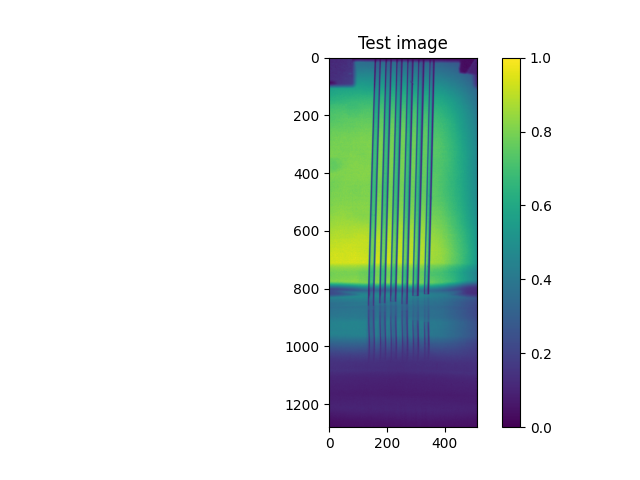

In [4]:
fig=plt.figure()

#frame=np.moveaxis(I.arr[-1,...],0,2).astype(np.float) # color
frame=I.arr[0,...].astype(float) # mono
plt.imshow(np.rot90(frame/np.nanmax(frame),3))
plt.colorbar()
plt.title("Test image");

## Background removal and cleanup

In [111]:
angle = 271.5
crop = (0,1000,130,-130)
bkgnd_frame = 100

# Use first image before liquid rises, as the reference
bk1 = I.arr[bkgnd_frame,...].astype(float) # mono
bk2 = si.rotate(bk1, angle) # rotate
bk = bk2[crop[0]:crop[1],crop[2]:crop[3]]

plt.close()
fig=plt.figure()
plt.imshow(bk)
plt.colorbar()
plt.title("Bkgnd image");

NameError: name 'I' is not defined

In [37]:
# Make new array with this removed
Ib = np.zeros((I.N,*bk.shape), float)

for i in tqdm.tqdm(range(I.shape()[0])):
    tmp1=si.rotate(I.arr[i,...], angle) # rotate
    tmp2=tmp1[crop[0]:crop[1],crop[2]:crop[3]] # crop
    Ib[i,...]=tmp2/(bk+1) # remove bkgnd

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3701/3701 [03:05<00:00, 19.91it/s]


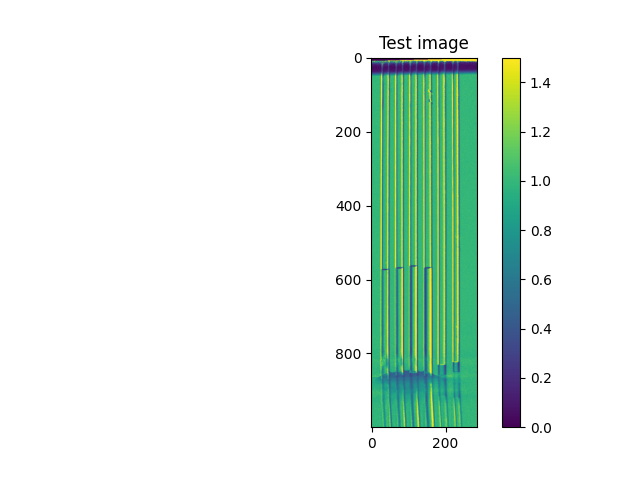

In [39]:
plt.close()
fig=plt.figure()
plt.imshow(Ib[-100,...],vmin=0,vmax=1.5)
plt.colorbar()
plt.title("Test image");

In [40]:
del I

## Capillaries - find approximate positions

[37, 76, 113, 152, 190, 227]


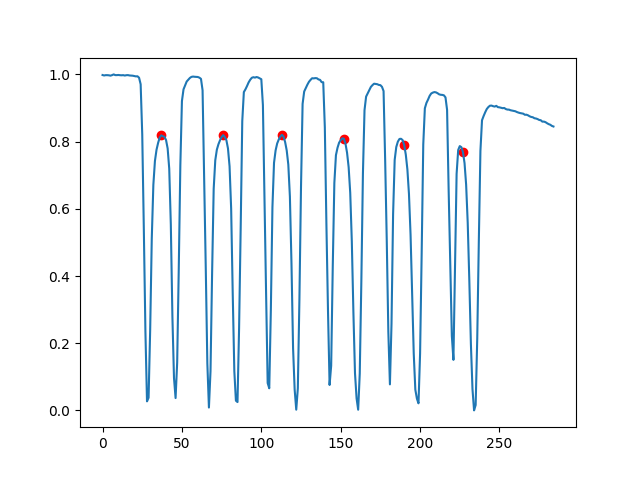

In [96]:
# average slice horizontally
x=np.arange(bk.shape[1])
z = np.mean(bk,axis=0)
z = (z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))

# find local minima
k=[]
for i in x[5:]:
    #if np.sign(z[i]-.5) != np.sign(z[i-1]-.5):
    if (z[i] == np.nanmin(z[i-5:i+4])) & (z[i]<.5):
        k.append(i)

# Estimate cap centers
k2=[]
for i in range(int(len(k)/2.)):
    k2.append(int((k[2*i]+k[2*i+1])/2.))

print(k2)

plt.close()
fig=plt.figure()
plt.plot(z);
plt.scatter(k2,z[k2],c='r');

## Capillaries - plot profiles

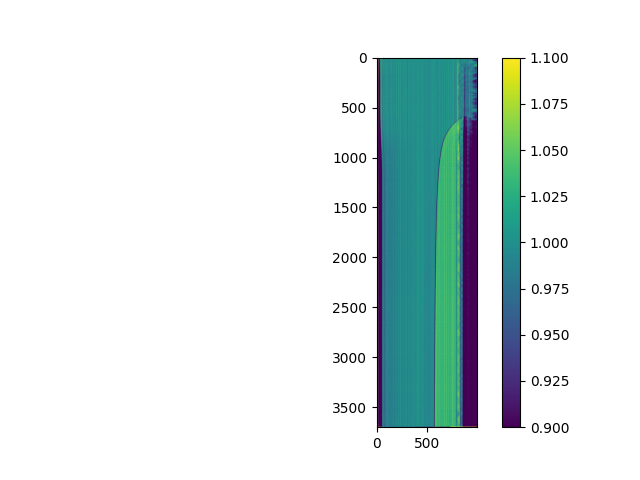

In [110]:
cap_profiles=[]

for i in k2:
    spacetime = np.mean( Ib[:,:,i-2:i+2],axis=2 )
    fig=plt.figure()
    plt.imshow(spacetime);
    plt.colorbar()
    break